## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import pandas as pd
from raptcr.hashing import TCRDistEmbedder
import seaborn as sns
from umap import UMAP

# Set directory
os.chdir('path_to_your_dir')

/var/folders/h1/5mmv2z5n7xz9rwls3g_gr7580000gn/T/ipykernel_1594/2113519049.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/sofiegielis/miniconda3/envs/new_raptcr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading simulated data

In [2]:
simulations = ['simulation1','simulation2','simulation3',
               'simulation4','simulation5','simulation6',
               'simulation7','simulation8']

df = []

for simulation in simulations:
    
    # Read data
    data = pd.read_csv(('./results/ligo_simulations/'+simulation+'/results/inst1/exported_dataset/airr/batch1.tsv'),
                       sep='\t', usecols=['junction_aa','signals_aggregated'])
    data['simulation']=simulation
    data['origin'] = data['simulation'] + '_' + data['signals_aggregated']
    df.append(data)
    
df = pd.concat(df)
df

,junction_aa,signals_aggregated,simulation,origin
0,CARGWTGENTEAFF,signal1,simulation1,simulation1_signal1
1,CASSFWTGAKDEQYF,signal1,simulation1,simulation1_signal1
2,CASSLGSTGEKYEQFF,signal1,simulation1,simulation1_signal1
3,CASSLAPGTGGKHEQFF,signal1,simulation1,simulation1_signal1
4,CASSLWGGKYEQYF,signal2,simulation1,simulation1_signal2
...,...,...,...,...
895,CASSSQPGLAGGTYEQYF,signal1,simulation8,simulation8_signal1
896,CASSLEPDRDLEKLFF,signal2,simulation8,simulation8_signal2
897,CASSLEGDGTGELFF,signal2,simulation8,simulation8_signal2
898,CASSLEGDSDYGYTF,signal2,simulation8,simulation8_signal2


In [3]:
# Merge multiple rows with the same cdr3 into one row
df_origin = (df.groupby(['junction_aa'])['origin'].apply(', '.join)
                 .reset_index().set_index('junction_aa'))
df_origin['origin'] = df_origin['origin'].apply(
    lambda x: x if ',' not in str(x) else ','.join(set(y.strip()
                                                   for y in x.split(',')))) 


# Merge multiple rows with the same cdr3 into one row
df_sim = (df.groupby(['junction_aa'])['simulation'].apply(', '.join)
                 .reset_index().set_index('junction_aa'))
df_sim['simulation'] = df_sim['simulation'].apply(
    lambda x: x if ',' not in str(x) else ','.join(set(y.strip()
                                                   for y in x.split(',')))) 
df = pd.concat([df_origin,df_sim],axis=1).reset_index()
df['simulation'] = df['simulation'].apply(lambda x: 'shared' if ',' in x else x)
df

,junction_aa,origin,simulation
0,CAAGDRSGINQPQHF,simulation3_signal2,simulation3
1,CACLATEFYPWGGAYEQYF,simulation6_signal1,simulation6
2,CACLGGLAAVQETQYF,simulation4_signal2,simulation4
3,CACTELAGGNQPQHF,simulation3_signal2,simulation3
4,CADRGLRRAYGYQPQHF,simulation1_signal3,simulation1
...,...,...,...
6869,CVPRDRGEVSGSNQPQHF,simulation3_signal2,simulation3
6870,CVQPWTGEAYEQYF,simulation1_signal1,simulation1
6871,CVRQGAPYNEQFF,simulation2_signal3,simulation2
6872,CVVAPGQETQYF,simulation4_signal2,simulation4


### Create CDR3 vectors

Each CDR3 is embedded as a vector of fixed length. The Euclidean distance between vectors of two TCRs equals their TCRdist score. In contrast to the varying-length strings, these vectors can be used with UMAP.

In [4]:
# CDR3 embedding without V genes
tcrdist = TCRDistEmbedder(full_tcr = False).fit()
tcrdist_embedding = tcrdist.transform(df)


/Users/sofiegielis/miniconda3/envs/new_raptcr/lib/python3.10/site-packages/raptcr/constants/preprocessing.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  L = len(cdrs[0])


In [5]:
# Add colors to df
#https://davidmathlogic.com/colorblind/#%23524F4F-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230072B2-%23D55E00-%23CC79A7
colors = {'simulation1':'#CC79A7',
          'simulation2':'#D55E00',
          'simulation3':'#0072B2',
          'simulation4':'#F0E442',
          'simulation5':'#009E73',
          'simulation6':'#56B4E9',
          'simulation7':'#E69F00',
          'simulation8':'#524F4F',
          'shared':'black'}

df['color'] = df['simulation'].apply(lambda x: colors[x] if x in list(colors.keys()) else 'NA')
df = df.sort_values(by='simulation', ascending=True)
df

,junction_aa,origin,simulation,color
5778,CASTRTSKGGGAYNEQFF,"simulation2_signal1,simulation7_signal1",shared,black
2760,CASSLEGGGYEQYF,"simulation3_signal1,simulation1_signal2",shared,black
2075,CASSGRLAGGGYEQYF,"simulation3_signal1,simulation8_signal1",shared,black
5873,CATGRRGADYNEQFF,"simulation2_signal3,simulation5_signal2",shared,black
1035,CASRPGGPYNEQFF,"simulation2_signal3,simulation4_signal1",shared,black
...,...,...,...,...
2892,CASSLFTGDFYEQYF,simulation8_signal3,simulation8,#524F4F
2761,CASSLEGGKDTEAFF,simulation8_signal2,simulation8,#524F4F
2581,CASSLASGGPYEQYF,simulation8_signal1,simulation8,#524F4F
3126,CASSLLLLGGPYNEQFF,simulation8_signal1,simulation8,#524F4F


### Select parameters
The same parameters were used as for the TCRex data

In [6]:
fit = UMAP(n_neighbors=15, min_dist=0.8) 
coordinates = fit.fit_transform(tcrdist_embedding) 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Umap of all simulations

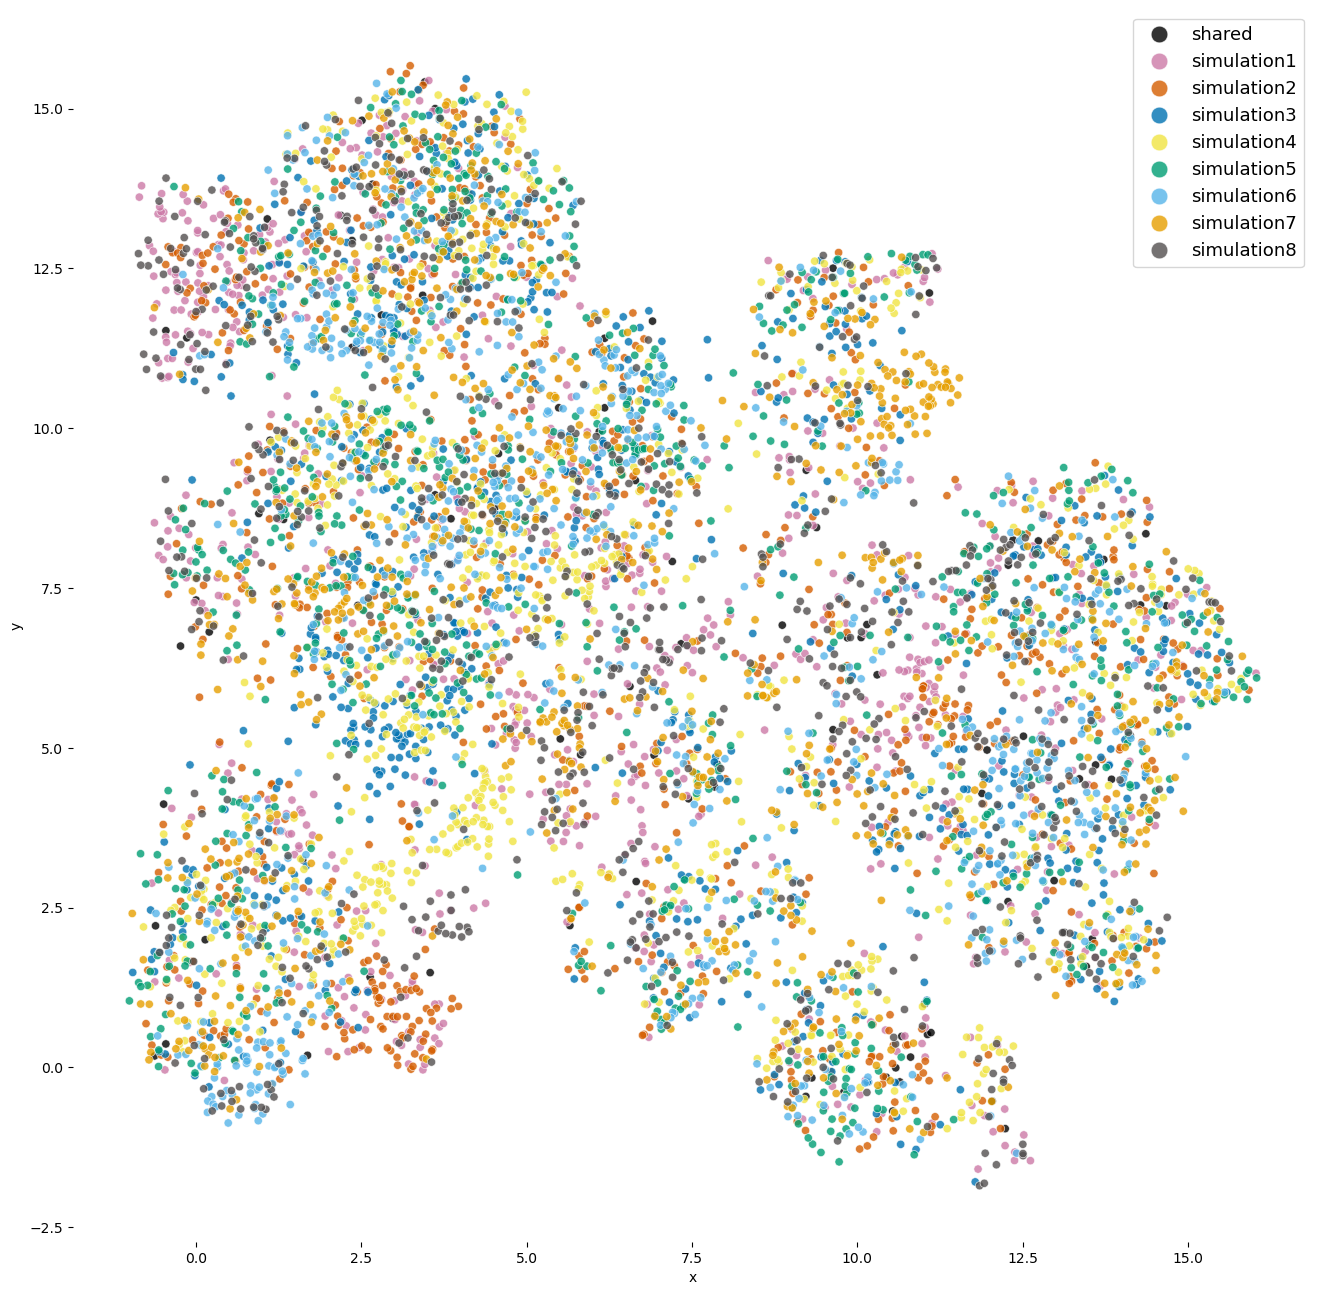

In [7]:
df["x"], df["y"] = zip(*coordinates)

fig_file =matplotlib.backends.backend_pdf.PdfPages('./figures/ligo_umap/all_simulations.pdf')


fig, ax = plt.subplots(figsize=(16,16))
sns.scatterplot(
    data = df,
    x="x",
    y="y",
    alpha=0.8,
    ax=ax,
    hue="simulation",
    palette=colors
)

plt.legend(loc='best',fontsize=13,markerscale=2)
sns.despine(bottom=True, left=True)

fig_file.savefig(fig)
fig_file.close()

### Coloring seeds per simulation

In [8]:
# Seed info
ligo_seeds = pd.read_csv('./docs/seeds.csv', sep=';')
ligo_seeds['Simulation'] = 'simulation' +ligo_seeds['Simulation'].astype(str)
ligo_seeds['Signal'] = 'signal' +ligo_seeds['Signal'].astype(str)
ligo_seeds['seed_id'] = ligo_seeds['Simulation'] + '_' + ligo_seeds['Signal']
ligo_seeds

,Simulation,Signal,Original TCR,Ligo seed,seed_id
0,simulation1,signal1,CSVWTGEKHEAFF,WTGEKHE,simulation1_signal1
1,simulation1,signal2,CSASSQRGGIYEQYF,SSQRGGIYE,simulation1_signal2
2,simulation1,signal3,CSAHLYRAYGYTF,HLYRAYG,simulation1_signal3
3,simulation2,signal1,CATKGTGLYNEQFF,KGTGLYNE,simulation2_signal1
4,simulation2,signal2,CASSYERGMNTEAFF,SYERGMNTE,simulation2_signal2
5,simulation2,signal3,CASSRAGADYNEQFF,SRAGADYNE,simulation2_signal3
6,simulation3,signal1,CASSLAVGGYEQYF,SLAVGGYE,simulation3_signal1
7,simulation3,signal2,CSVELSGINQPQHF,ELSGINQP,simulation3_signal2
8,simulation3,signal3,CASSRGSAETQYF,SRGSAET,simulation3_signal3
9,simulation4,signal1,CSAPIPPYNEQFF,PIPPYNE,simulation4_signal1


In [9]:
# Add info from othere data frames
def get_info(data, column, row, info):
    selection = data[data[column]==row]
    return ','.join(selection[info])

/var/folders/h1/5mmv2z5n7xz9rwls3g_gr7580000gn/T/ipykernel_1594/3336975735.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection['seed'] = selection['origin'].apply(lambda x: get_info(ligo_seeds, 'seed_id', x,'Ligo seed'))
/var/folders/h1/5mmv2z5n7xz9rwls3g_gr7580000gn/T/ipykernel_1594/3336975735.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection['seed'] = selection['origin'].apply(lambda x: get_info(ligo_seeds, 'seed_id', x,'Ligo seed'))
/var/folders/h1/5mmv2z5n7xz9rwls3g_gr7580000gn/T/i

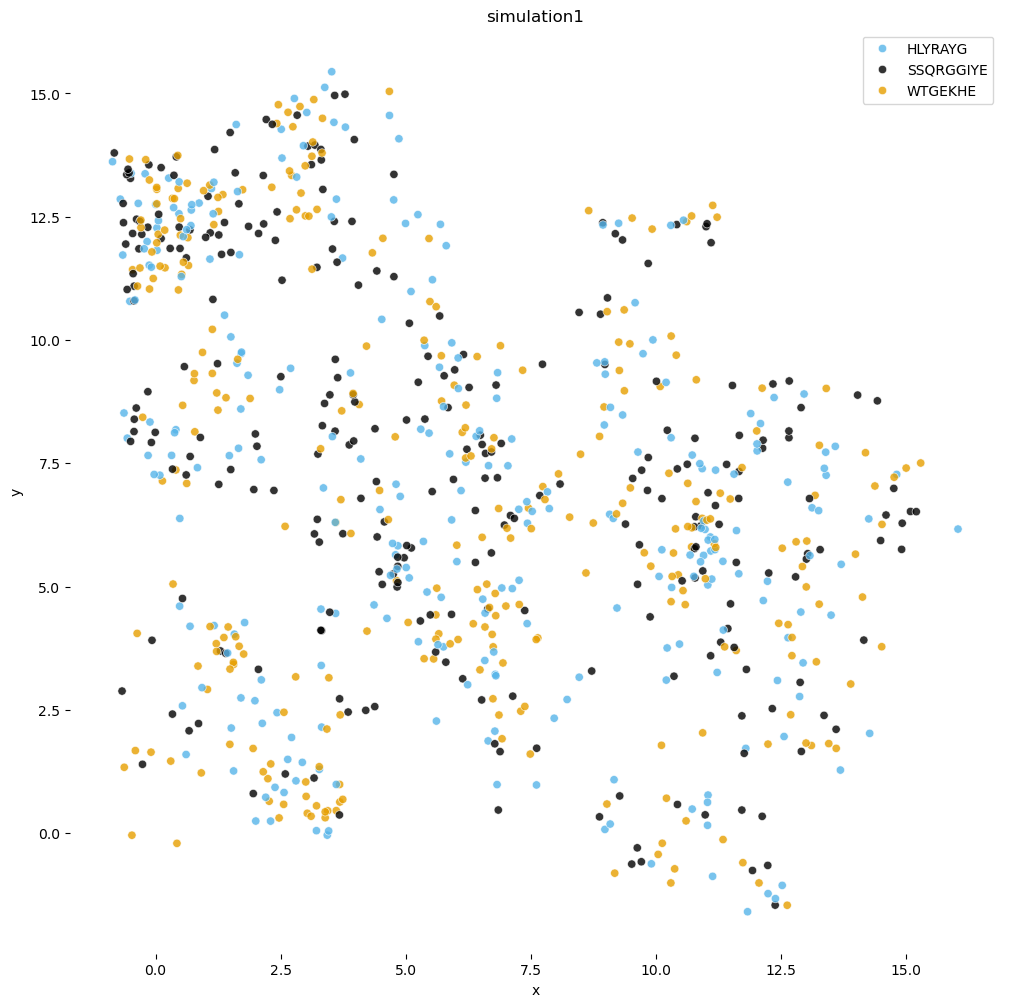

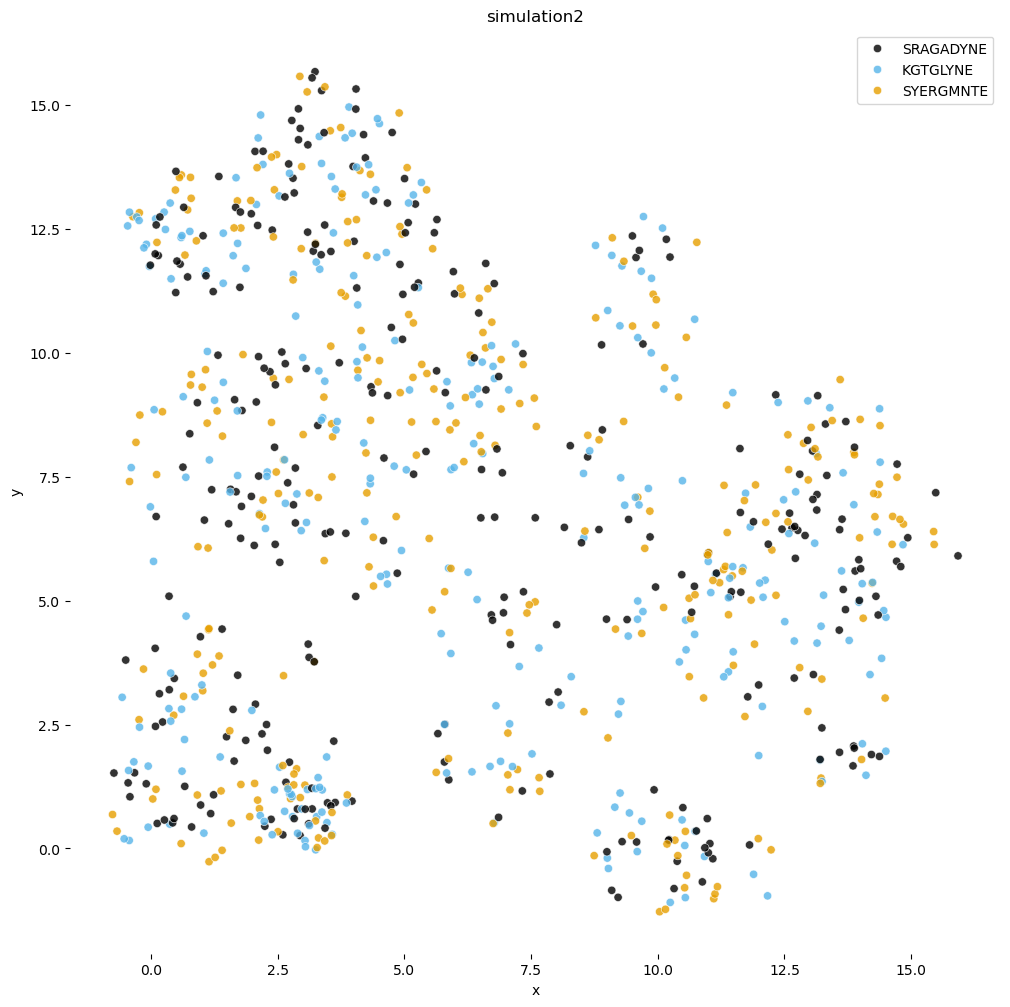

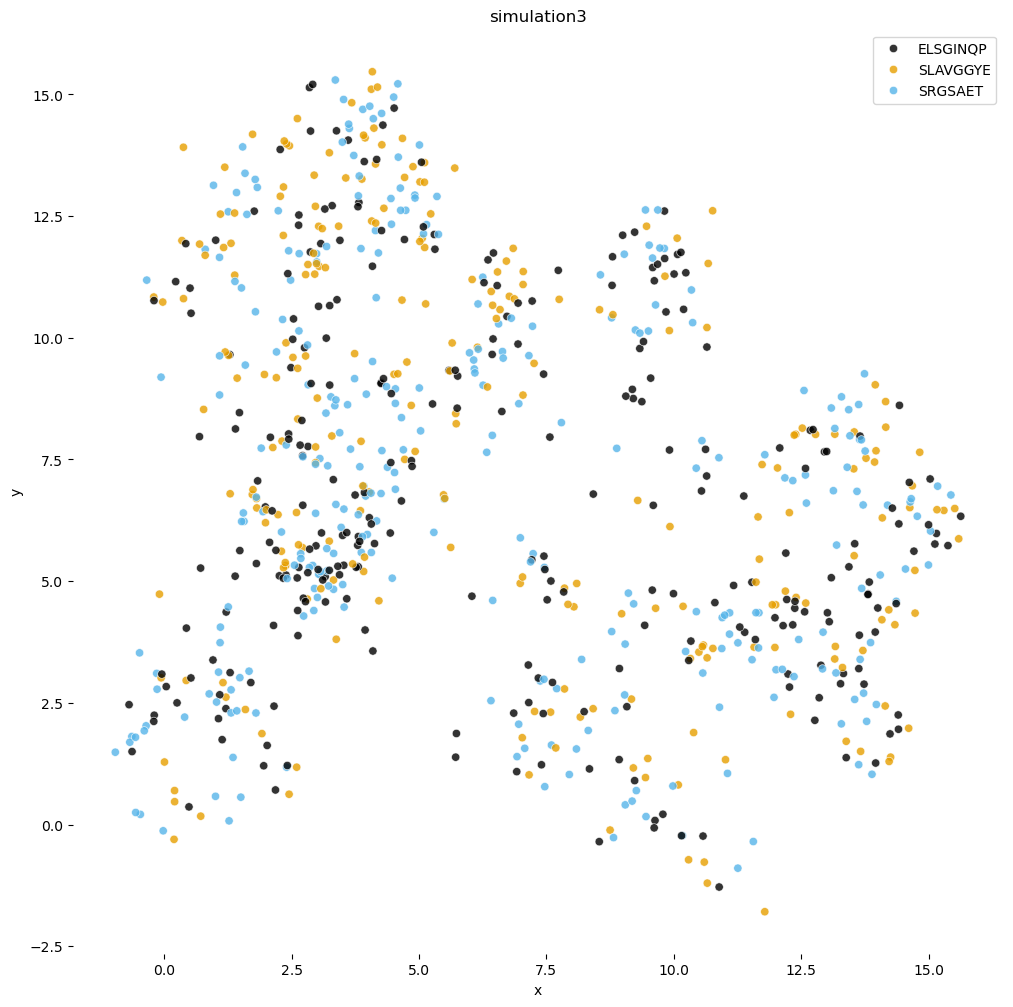

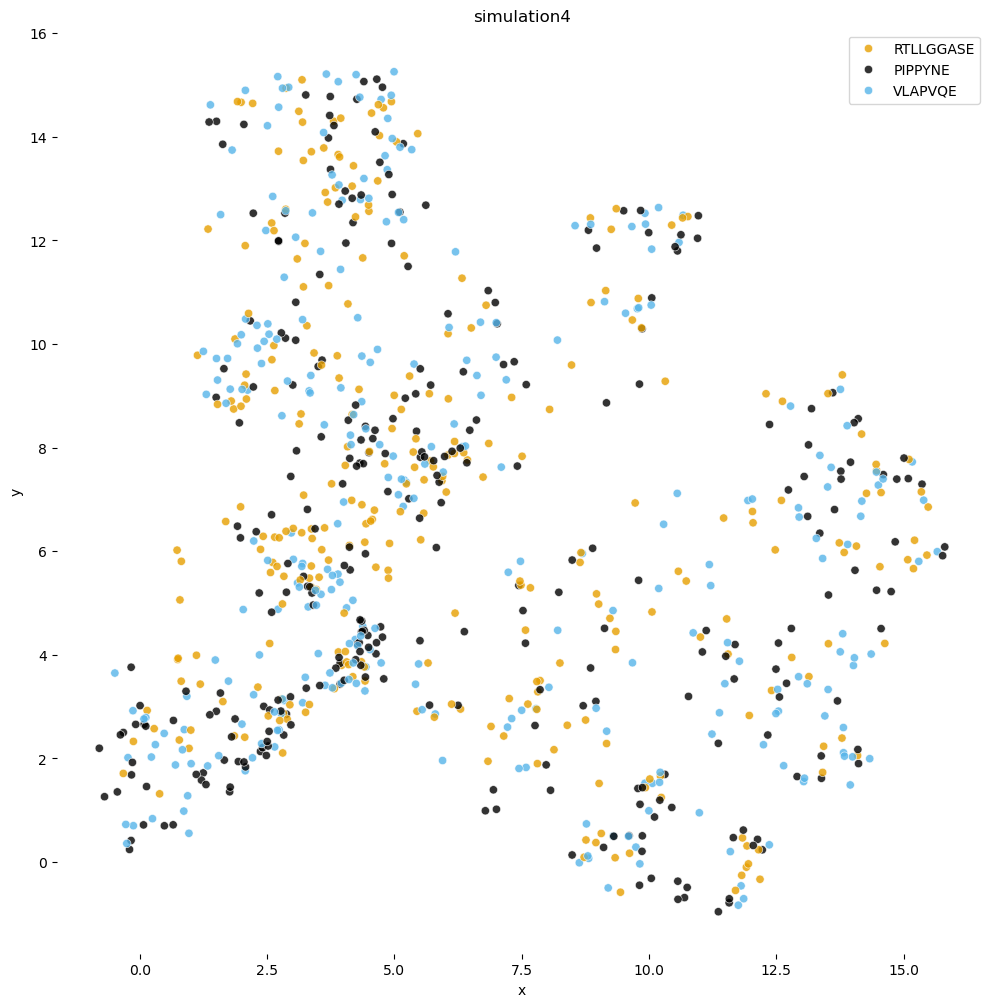

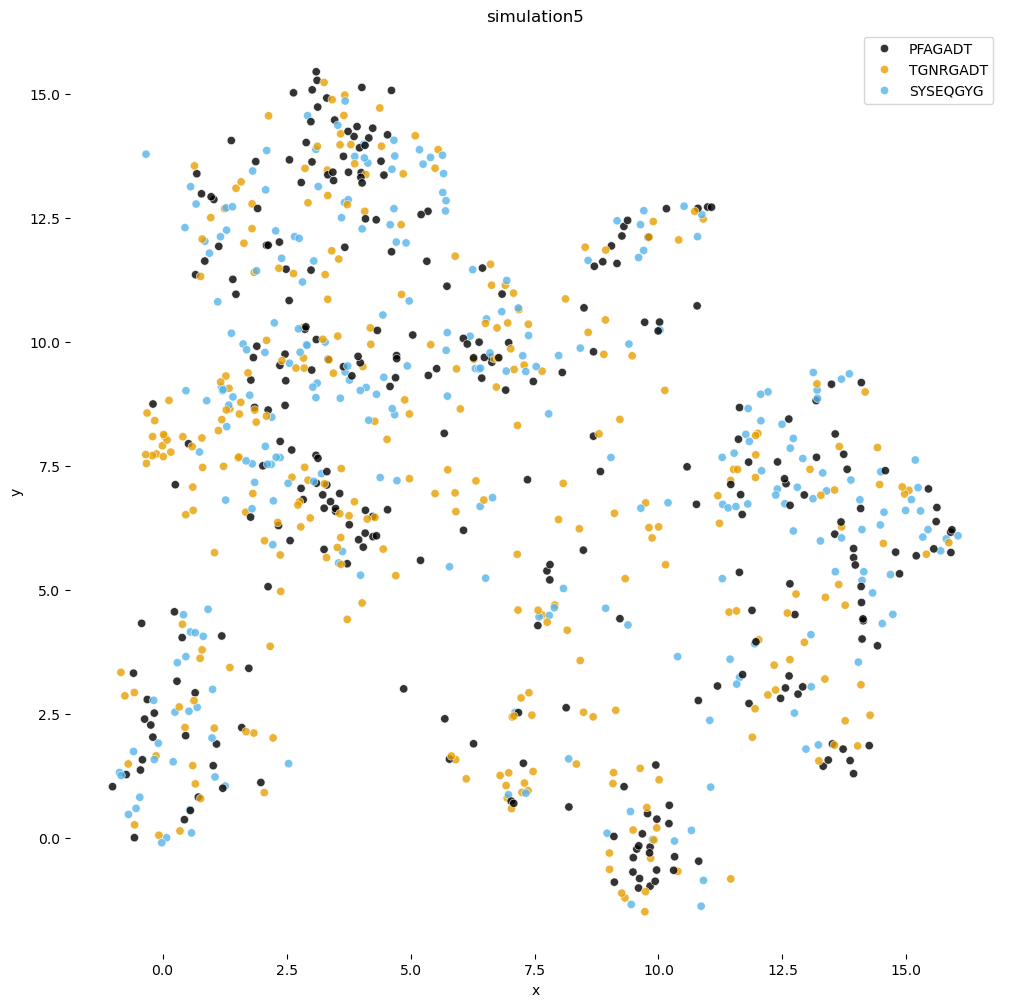

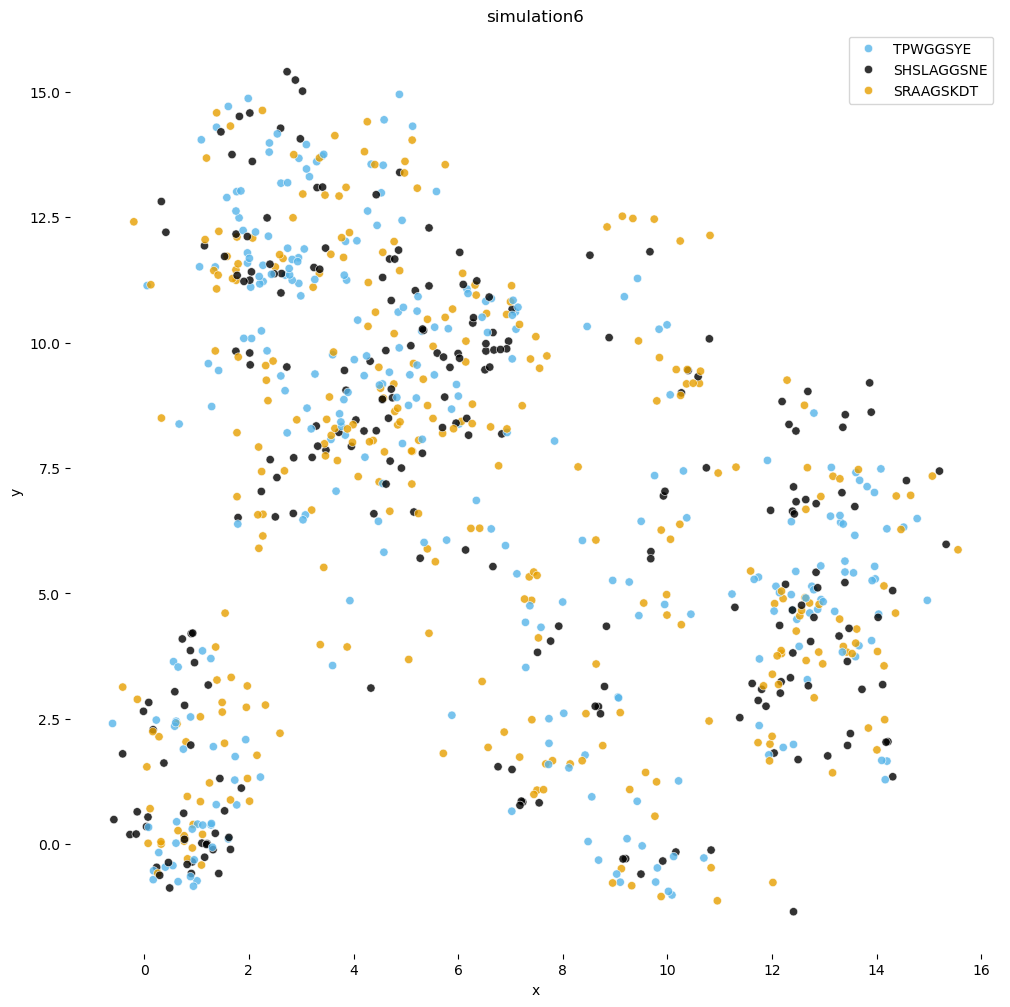

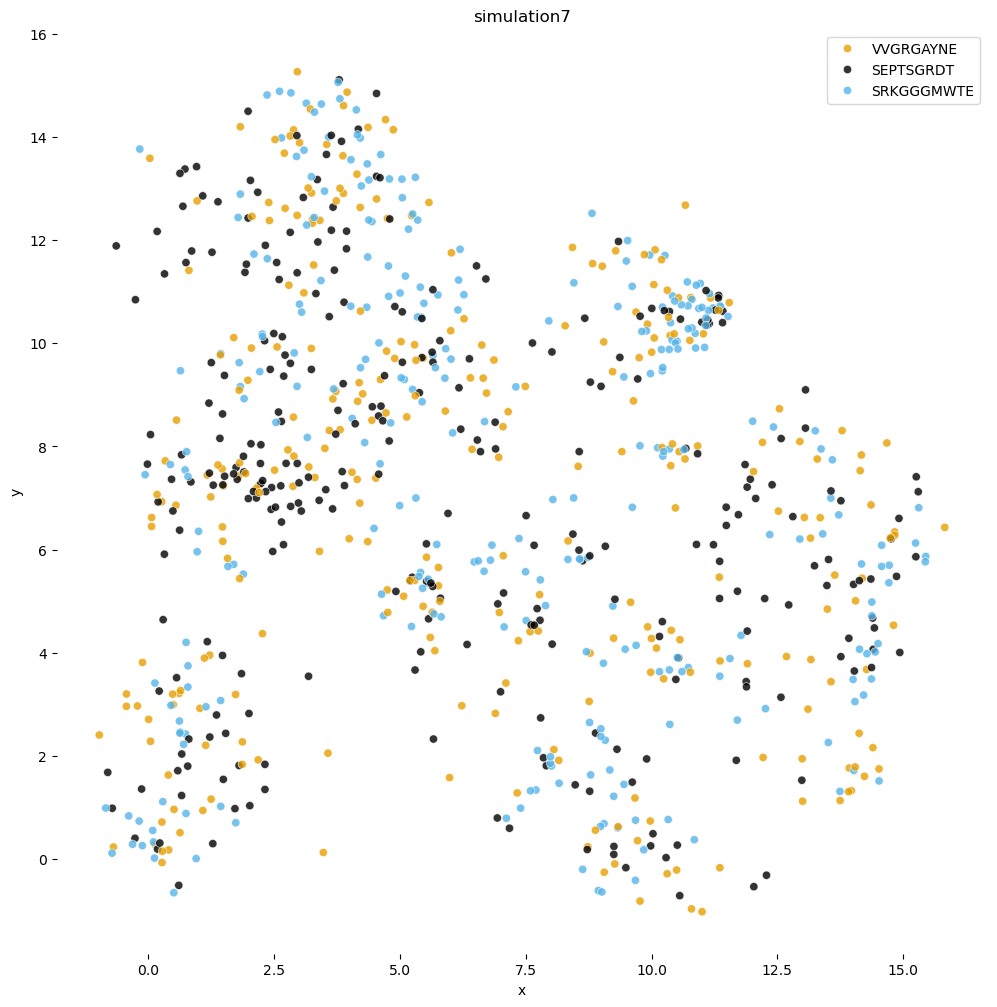

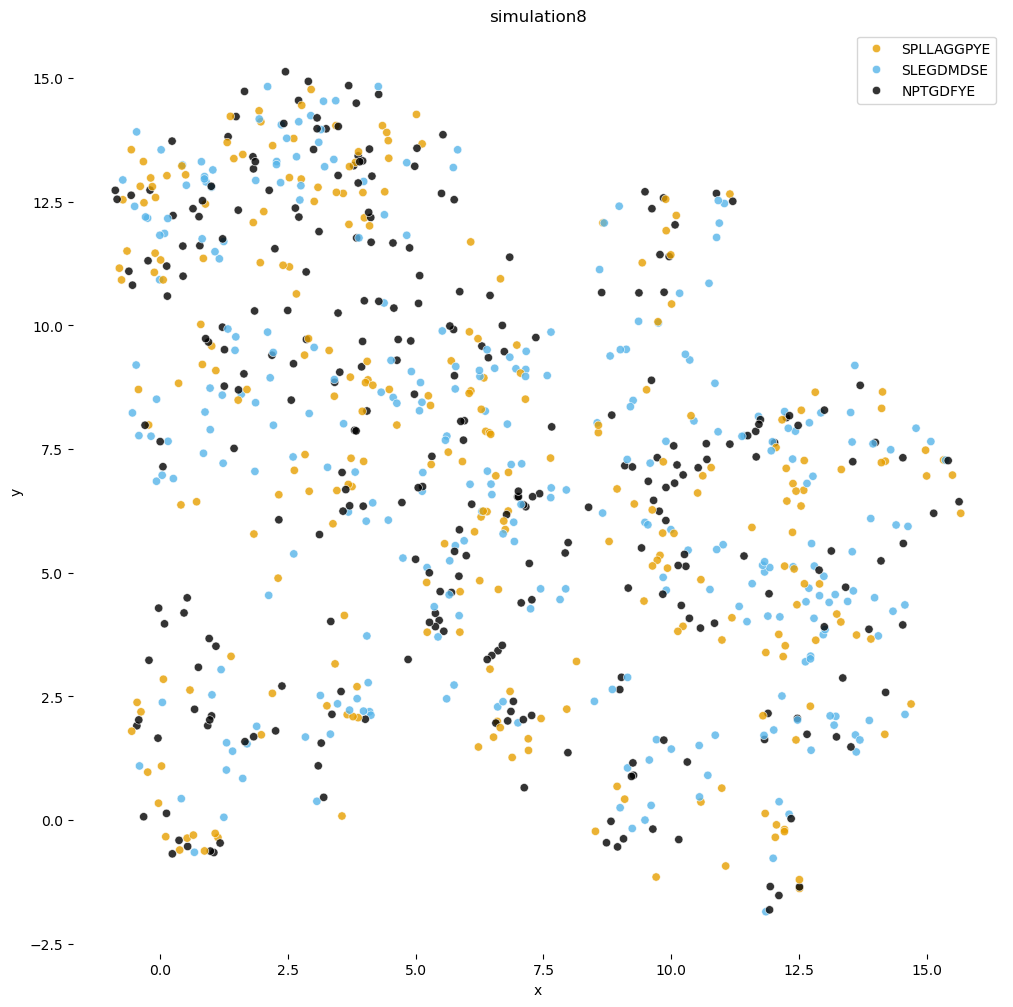

In [10]:
for simulation in simulations:
    
    fig_file =matplotlib.backends.backend_pdf.PdfPages('./figures/ligo_umap/'+simulation+'.pdf')
    
    # Select only the data of one simulation
    selection = df[df['simulation']==simulation]
    
    # Define colors by seed sequences
    selection['seed'] = selection['origin'].apply(lambda x: get_info(ligo_seeds, 'seed_id', x,'Ligo seed'))
    signal1, signal2,signal3, = set(selection['seed'].tolist())
    # palette:https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9
    colors={signal1:'#000000', signal2:'#E69F00', signal3:'#56B4E9'}
    

    fig, ax = plt.subplots(figsize=(12,12))

    sns.scatterplot(
        data = selection,
        x="x",
        y="y",
        alpha=0.8,
        ax=ax,
        hue="seed",
        palette=colors
    )
    plt.title(simulation)
    ax.legend(bbox_to_anchor=(1,1))
    sns.despine(bottom=True, left=True)
    
    fig_file.savefig(fig)
    fig_file.close()